# Question 1.5

In [1]:


import numpy as np

from astropy.table import Table


table1 = Table.read('dhawan_table1_abridged.txt',format='ascii')
table2 = Table.read('dhawan_table2_abridged.txt',format='ascii')




In [2]:
m_k=table1['col3']
sigma_m_k=table1['col4']
mu_k = table1['col5']
sigma_c_k = table1['col6']

In [3]:
z_i=table2['col3']
m_i = table2['col4']
sigma_m_i = table2['col5']



In [4]:
def M0_hat(m_k,sigma_m_k, mu_k,sigma_c_k,sigma_int):
    
    tau_k = np.sqrt(sigma_m_k**2 + sigma_c_k**2 + sigma_int**2)
    
    return np.sum(tau_k**(-2)*(m_k-mu_k))/np.sum(tau_k**(-2))


def theta_hat(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,sigma_int):
                  
    
    M0_hat_=M0_hat(m_k,sigma_m_k, mu_k,sigma_c_k,sigma_int)

    sigma_i = np.sqrt(sigma_m_i**2 +sigma_int**2)
                  
    
                  
                  
    return M0_hat_ - np.sum(sigma_i**(-2)*(m_i-25-5*np.log10(3e5*z_i/100)))/np.sum(sigma_i**(-2))
                  
                  
                  
                  
                  
                  
def h_hat(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,sigma_int):
    
    theta_hat_ = theta_hat(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,sigma_int)
    
    
    return 10**(theta_hat_/5)
                
                

        
def theta_var(sigma_m_k,sigma_m_i,sigma_c_k,sigma_int):
    tau_k = np.sqrt(sigma_m_k**2+sigma_c_k**2+sigma_int**2)
    sigma_i = np.sqrt(sigma_m_i**2+sigma_int**2)

    return np.sum(tau_k**(-2))**(-1) + np.sum(sigma_i**(-2))**(-1)
    
    
def h_err(h,sigma_m_k,sigma_m_i,sigma_c_k,sigma_int):
    
    theta_var_ = theta_var(sigma_m_k,sigma_m_i,sigma_c_k,sigma_int)
    
    
    return np.log(10)/5 * h * np.sqrt(theta_var_)

h_hat_=h_hat(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,sigma_int=0.1)
h_err_ = h_err(h_hat_,sigma_m_k,sigma_m_i,sigma_c_k,sigma_int=0.1)

print('h:', h_hat_,' +/- ',h_err_)                 

    
h_hat_=h_hat(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,sigma_int=0.16)
h_err_ = h_err(h_hat_,sigma_m_k,sigma_m_i,sigma_c_k,sigma_int=0.16)




print('h:', h_hat_,' +/- ',h_err_)                 

                  
    

h: 0.7176424814964795  +/-  0.015345884572886225
h: 0.7164015299120874  +/-  0.022470352212204867


Increasing sigma_int slightly decreases h and also increases the uncertainty.

# Question 1.6

In [5]:
def log_likelihood(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,M0,theta,sigma_int):
    
    tau_k = np.sqrt(sigma_m_k**2+sigma_c_k**2+sigma_int**2)
    
    sig_i = np.sqrt(sigma_m_i**2+sigma_int**2)
    
    cal_log_l=np.sum(-np.log(tau_k*np.sqrt(2*np.pi))-0.5*((m_k-mu_k-M0)/tau_k)**2)
    
    flow_log_l =np.sum(-np.log(sig_i*np.sqrt(2*sig_i))-0.5*((m_i-25-5*np.log10(3e5*z_i/100)-M0+theta)/sig_i)**2)
    
    return  cal_log_l +flow_log_l





log_likelihood(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,-19.5,-3,0.1)

import numpy as np
from scipy.optimize import minimize






def objective_function(params):
    M0_, theta_, sigma_int_ = params
    
    if theta_<0:
        penalty = 100000
        
    else:
        penalty = 0
    
    
    return -log_likelihood(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,M0_,theta_,sigma_int_) + penalty


initial_guess = [-19.5,-0.77,0.1]

result = minimize(objective_function, initial_guess, method='BFGS',options ={'eps': 1e-4}) 


optimized_params = result.x


optimized_value = result.fun

opt_M0, opt_theta, opt_sigma_int = optimized_params

opt_h = 10**(opt_theta/5)

print('optimized params:')
print('M0: ',opt_M0)
print('theta: ',opt_h)
print('h: ', 10**(opt_theta/5))
print('sigma_int: ',opt_sigma_int)

optimized params:
M0:  -18.524504432659864
theta:  0.7175312443816019
h:  0.7175312443816019
sigma_int:  0.09744677030019433


In [6]:
def calculate_hessian(func, point, epsilon=1e-5):
    n = len(point)
    hessian = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            hessian[i][j] = (func(point + np.array([i==0, i==1, i==2]) * epsilon + np.array([j==0, j==1, j==2]) * epsilon)
                             - 2 * func(point)
                             + func(point - np.array([i==0, i==1, i==2]) * epsilon - np.array([j==0, j==1, j==2]) * epsilon)) / (epsilon**2)

    return hessian

def log_like(params):
    M0_, h_, sigma_int_ = params
    
    
    theta_ = 5*np.log10(h_)
    
    return log_likelihood(m_k,sigma_m_k, mu_k,sigma_c_k,m_i,sigma_m_i,z_i,M0_,theta_,sigma_int_) 


hessian_matrix = calculate_hessian(log_like,[opt_M0, opt_h, opt_sigma_int])



print('Information Matrix:')
print(-hessian_matrix)

print('ERB:')

var = np.linalg.inv(-hessian_matrix)
print(var)

print('optimized params:')
print('M0: ',opt_M0, ' +/- ', np.sqrt(var[0,0]))
print('h: ', 10**(opt_theta/5), ' +/- ', np.sqrt(var[1,1]))
print('sigma_int: ',opt_sigma_int, ' +/- ', np.sqrt(var[2,2]))


Information Matrix:
[[12592.73119558 11080.38773623 10621.04487914]
 [11080.38773623 93556.92014879 31675.76522856]
 [10621.04487914 31675.76522856 30603.86191578]]
ERB:
[[ 1.12276531e-04 -1.61361249e-07 -3.87984639e-05]
 [-1.61361249e-07  1.64552573e-05 -1.69756040e-05]
 [-3.87984639e-05 -1.69756040e-05  6.37107656e-05]]
optimized params:
M0:  -18.524504432659864  +/-  0.010596062039421202
h:  0.7175312443816019  +/-  0.004056508018209562
sigma_int:  0.09744677030019433  +/-  0.007981902382316573


# Question 3.3

In [7]:
table = Table.read('sn_cosm_simple1000.txt',format='ascii')
zs = table['col1']
ms = table['col2']

In [8]:

from astropy.cosmology import LambdaCDM




n_sne = len(zs)



def logpost(M,log_sigma_int,log_omega_m,omega_l,prior='uniform'):
    
    
    
    omega_m = np.exp(log_omega_m)
    sigma_int = np.exp(log_sigma_int)
    
    
    
    
    cosmo = LambdaCDM(H0=72, Om0=omega_m, Ode0=omega_l)
    
    d = cosmo.luminosity_distance(zs)
    
    d = d.value
    
    mo = M + 25 + 5*np.log10(3e5*d / 100)
    
    
    
    
    
    log_likelihood = -n_sne*np.log(sigma_int*np.sqrt(2*np.pi)) -0.5*(1/sigma_int**2)*np.sum((ms-mo)**2)
    
    log_prior = 0
    
    if prior == 'cmb':
        
        cmb_sig = np.sqrt(0.04/1.41)
        
        cmb_mu = ((1.3-omega_m)/1.41)
        

        log_prior +=-np.log(cmb_sig*np.sqrt(2*np.pi)) -0.5*(1/cmb_sig**2)*(omega_l-cmb_mu)**2
        

    return log_likelihood + log_prior




def run_mc(n_mc,prior='uniform'):



    mc = np.zeros((n_mc,4))

    acc = 0



    M = -38 - 5*np.log10(0.72)
    log_sigma_int = np.log(0.1)
    log_omega_m = np.log(0.3)
    omega_l = 0.7



    logpost_curr = logpost(M,log_sigma_int,log_omega_m,omega_l,prior=prior)



    sigma_prop_M = 0.01
    sigma_prop_sig = 0.01
    sigma_prop_m = 0.01
    sigma_prop_l = 0.01




    print('Running MCMC for '+str(n_mc)+' steps...')

    for i in range(n_mc):
    

    
        M_prop = M + sigma_prop_M*np.random.normal()
    
        sig_prop = log_sigma_int + sigma_prop_sig*np.random.normal()
    
        m_prop = log_omega_m + sigma_prop_m*np.random.normal()
    
        l_prop= omega_l + sigma_prop_l*np.random.normal()
    
    
        logpost_prop = logpost(M_prop,sig_prop,m_prop,l_prop,prior=prior)

    
        logr = logpost_prop - logpost_curr
    

        if np.log(np.random.rand()) <= logr:
        

        

        
    
            M = M_prop 
    
            log_sigma_int =sig_prop 
    
            log_omega_m = m_prop
    
            omega_l = l_prop 
        
            logpost_curr = logpost_prop
    
        

        
        mc[i,:] = np.array([M,log_sigma_int,log_omega_m,omega_l])
    return mc


    


In [9]:
uniform_samps = run_mc(100000,prior='uniform')

Running MCMC for 100000 steps...


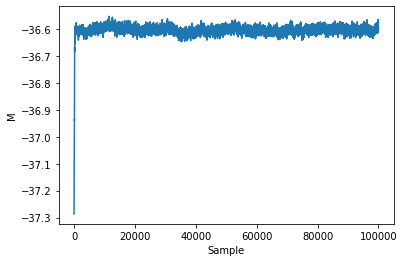

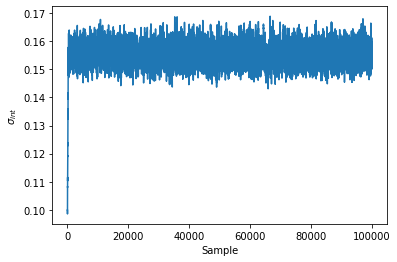

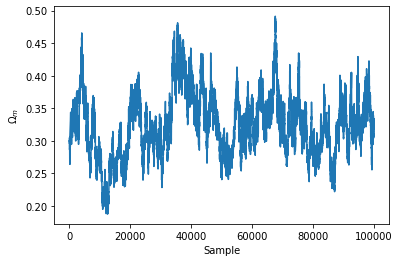

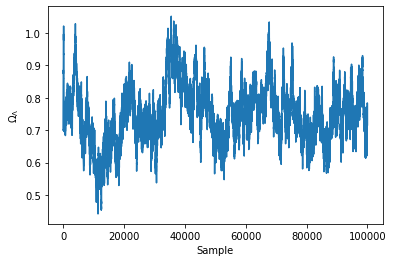

In [10]:
from matplotlib import pyplot as plt
plt.plot(uniform_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(uniform_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(uniform_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{\Lambda}$')
plt.show()

In [11]:
cmb_samps = run_mc(100000,prior='cmb')

Running MCMC for 100000 steps...


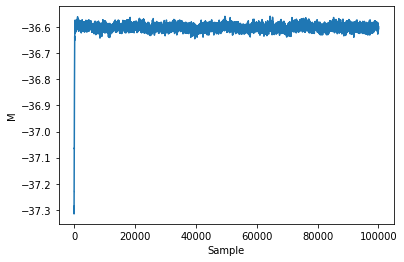

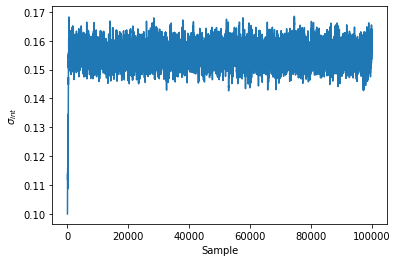

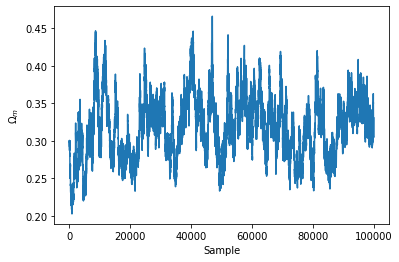

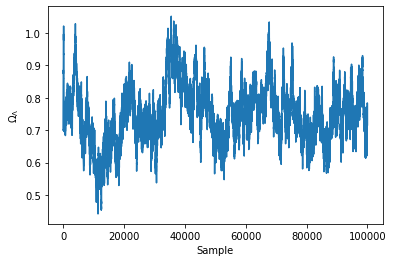

In [12]:
plt.plot(cmb_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(cmb_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(cmb_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{\Lambda}$')
plt.show()

Compare uniform vs CMB prior samples

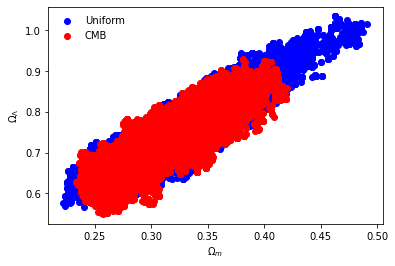

In [13]:
plt.scatter(np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3],color='blue',label='Uniform')
plt.scatter(np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3],color='red',label='CMB')
plt.legend(frameon=False)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{\Lambda}$')
plt.show()




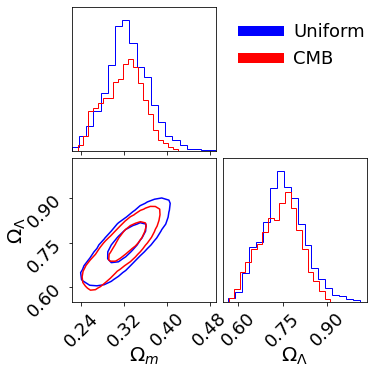

In [14]:
import corner
import matplotlib.lines as mlines
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
labels_plot=[r'$\Omega_m$',r'$\Omega_{\Lambda}$']
plot_uniform = np.array([np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3]]).T
fig=corner.corner(plot_uniform,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='blue',labelpad=0,title_fmt='.3f')
plot_cmb = np.array([np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3]]).T
corner.corner(plot_cmb,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='red',labelpad=0,title_fmt='.3f',fig=fig)


blue_line = mlines.Line2D([], [], color='blue', label=r'Uniform',linewidth=10)
red_line = mlines.Line2D([], [], color='red', label=r'CMB',linewidth=10)
plt.legend(handles=[blue_line,red_line], frameon=False,bbox_to_anchor=(1, 2, 0.1, 0.05),loc='upper right')
plt.show()
matplotlib.rcParams.update({'font.size': 12})

# Question 3.4

In [15]:

from astropy.cosmology import wCDM



n_sne = len(zs)



def logpost2(M,log_sigma_int,log_omega_m,w,prior='uniform'):
    
    
    
    omega_m = np.exp(log_omega_m)
    sigma_int = np.exp(log_sigma_int)
    
    omega_l = 1-omega_m
    
    cosmo = wCDM(H0=72, Om0=omega_m, Ode0=omega_l,w0=w)
    
    d = cosmo.luminosity_distance(zs)
    
    d = d.value
    
    mo = M + 25 + 5*np.log10(3e5*d / 100)
    
    
    
    
    
    log_likelihood = -n_sne*np.log(sigma_int*np.sqrt(2*np.pi)) -0.5*(1/sigma_int**2)*np.sum((ms-mo)**2)
    log_prior = 0
    
    if prior == 'cmb':
        
        cmb_sig = np.sqrt(0.04/1.41)
        
        cmb_mu = ((1.3-omega_m)/1.41)
        

        log_prior +=-np.log(cmb_sig*np.sqrt(2*np.pi)) -0.5*(1/cmb_sig**2)*(omega_l-cmb_mu)**2
        

    return log_likelihood + log_prior




def run_mc2(n_mc,prior='uniform'):



    mc = np.zeros((n_mc,4))

    acc = 0

    M = -38 - 5*np.log10(0.72)
    log_sigma_int = np.log(0.1)
    log_omega_m = np.log(0.3)
    w = -1


    logpost_curr = logpost2(M,log_sigma_int,log_omega_m,w,prior=prior)


    sigma_prop_M = 0.01
    sigma_prop_sig = 0.01
    sigma_prop_m = 0.01
    sigma_prop_w = 0.01




    print('Running MCMC for '+str(n_mc)+' steps...')

    for i in range(n_mc):
        

    

    
        M_prop = M + sigma_prop_M*np.random.normal()
    
        sig_prop = log_sigma_int + sigma_prop_sig*np.random.normal()
    
        m_prop = log_omega_m + sigma_prop_m*np.random.normal()
    
        w_prop= w + sigma_prop_w*np.random.normal()
    
    
        logpost_prop = logpost2(M_prop,sig_prop,m_prop,w_prop,prior=prior)

    
        logr = logpost_prop - logpost_curr
    

        if np.log(np.random.rand()) <= logr:
        

        

        
    
            M = M_prop 
    
            log_sigma_int =sig_prop 
    
            log_omega_m = m_prop
    
            w = w_prop 
        
            logpost_curr = logpost_prop
    
        

        
        mc[i,:] = np.array([M,log_sigma_int,log_omega_m,w])
    return mc


    


In [16]:
uniform_samps = run_mc2(100000,prior='uniform')

Running MCMC for 100000 steps...


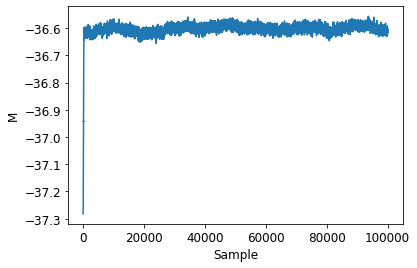

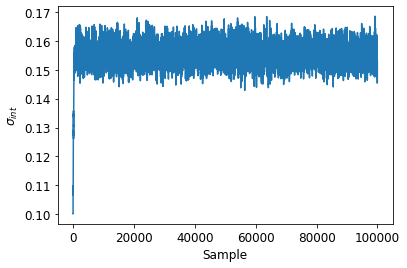

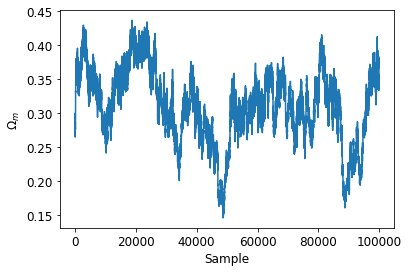

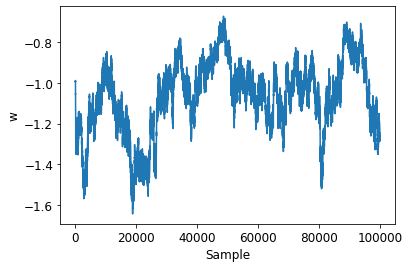

In [17]:
from matplotlib import pyplot as plt
plt.plot(uniform_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(uniform_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(uniform_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel('w')
plt.show()

In [18]:
cmb_samps = run_mc2(100000,prior='cmb')

Running MCMC for 100000 steps...


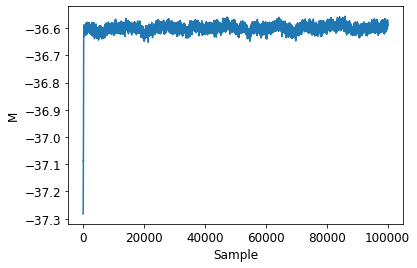

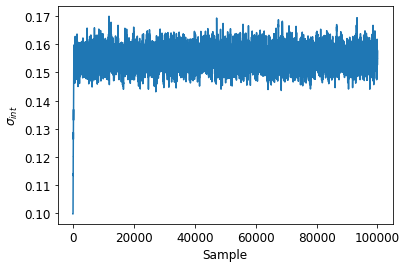

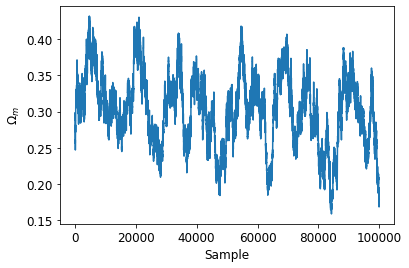

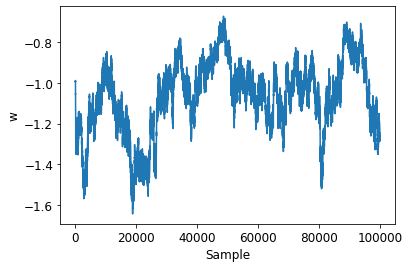

In [19]:
plt.plot(cmb_samps[:,0])
plt.xlabel('Sample')
plt.ylabel('M')
plt.show()
plt.plot(np.exp(cmb_samps[:,1]))
plt.xlabel('Sample')
plt.ylabel(r'$\sigma_{int}$')
plt.show()
plt.plot(np.exp(cmb_samps[:,2]))
plt.xlabel('Sample')
plt.ylabel(r'$\Omega_{m}$')
plt.show()
plt.plot(uniform_samps[:,3])
plt.xlabel('Sample')
plt.ylabel('w')
plt.show()

Compare uniform vs CMB samples

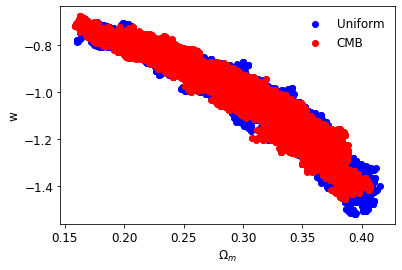

In [20]:
plt.scatter(np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3],color='blue',label='Uniform')
plt.scatter(np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3],color='red',label='CMB')
plt.legend(frameon=False)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'w')
plt.show()


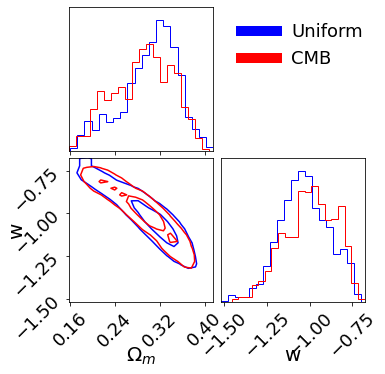

In [21]:
import corner
import matplotlib.lines as mlines
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
labels_plot=[r'$\Omega_m$',r'w']
plot_uniform = np.array([np.exp(uniform_samps[60000:,2]),uniform_samps[60000:,3]]).T
fig=corner.corner(plot_uniform,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='blue',labelpad=0,title_fmt='.3f')
plot_cmb = np.array([np.exp(cmb_samps[60000:,2]),cmb_samps[60000:,3]]).T
corner.corner(plot_cmb,labels=labels_plot,smooth=0.9,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    label_kwargs=dict(fontsize=20),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,truth_color='black',color='red',labelpad=0,title_fmt='.3f',fig=fig)


blue_line = mlines.Line2D([], [], color='blue', label=r'Uniform',linewidth=10)
red_line = mlines.Line2D([], [], color='red', label=r'CMB',linewidth=10)
plt.legend(handles=[blue_line,red_line], frameon=False,bbox_to_anchor=(1, 2, 0.1, 0.05),loc='upper right')
plt.show()
matplotlib.rcParams.update({'font.size': 12})

# Question 4.3

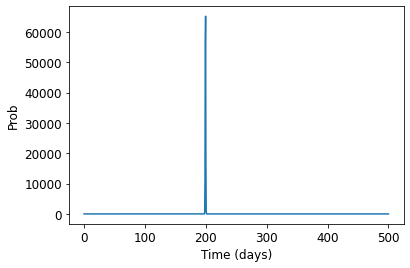

Best T: 199.70570570570572
Best A 0.948786615275984
Best l_hat -0.9139851255605929


In [22]:
table = Table.read('variable_star.txt',format='ascii')
t=np.array(table['col1'])
m = np.array(table['col2'])
sigma_m = np.array(table['col3'])



def periodic_kernel(t,t_,theta,T):
    
    A = theta[0]
    l_bar = theta[1]
    
    
    
    return A**2 * np.exp(-2*l_bar**2 * np.sin(np.pi*(t-t_)/T)**2)

def eval_log_gauss(x,mu,cov,):
    
    N = x.size
    
    
    L = np.linalg.cholesky(cov)
        
    
    det_cov =  2 * np.sum(np.log(np.diag(L)))
        
 
    x=x.reshape(N,1)
    mu = mu.reshape(N,1)

    diff = x-mu
        
  
    z = np.linalg.solve(L,diff)


    
    return -N*0.5*np.log(2*np.pi)-0.5*det_cov-0.5*(z.T@z)

    
    
def marginal_log_likelihood(t,m,sigma_m,theta,T):
    
    
    N = t.size
    
    t = t.reshape(N,1)
    
    
    
    cov = periodic_kernel(t,t.T,theta,T) + np.diag(sigma_m**2)

    mu = np.zeros(N).reshape(N,1)
    
    m=m.reshape(N,1)
    
    return eval_log_gauss(m,mu,cov).reshape(1)[0]


T_grid = np.linspace(0.01,500,1000)


from scipy.optimize import minimize

best = 100
log_probs = []
for T_trial in T_grid:
    
    
    def objective_function(theta):
        
        
        
         return -marginal_log_likelihood(t,m,sigma_m,theta,T_trial)
    
    
    initial_guess = [1,10]

    result = minimize(objective_function, initial_guess, method='BFGS',options ={'eps': 1e-4}) 
    log_probs+=[-result.fun]
    if result.fun<best:
        best=result.fun
        best_theta=result.x
        best_T=T_trial
        
        
plt.plot(T_grid,np.exp(log_probs))
plt.xlabel('Time (days)')
plt.ylabel('Prob')
plt.show()
print('Best T:',best_T)
print('Best A',best_theta[0])
print('Best l_hat',best_theta[1])

# Question 4.4

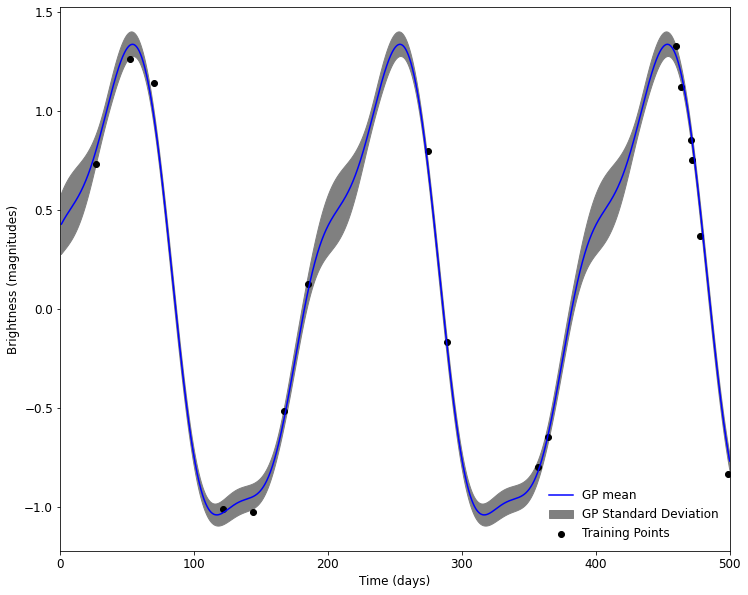

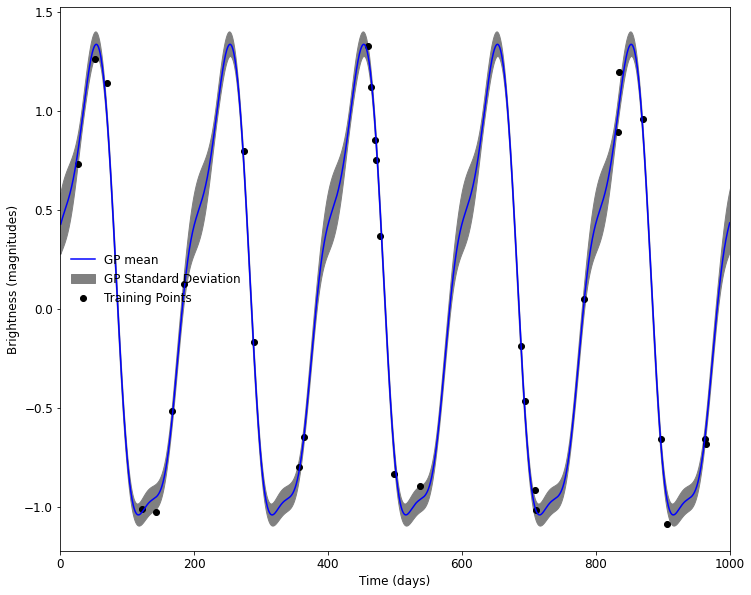

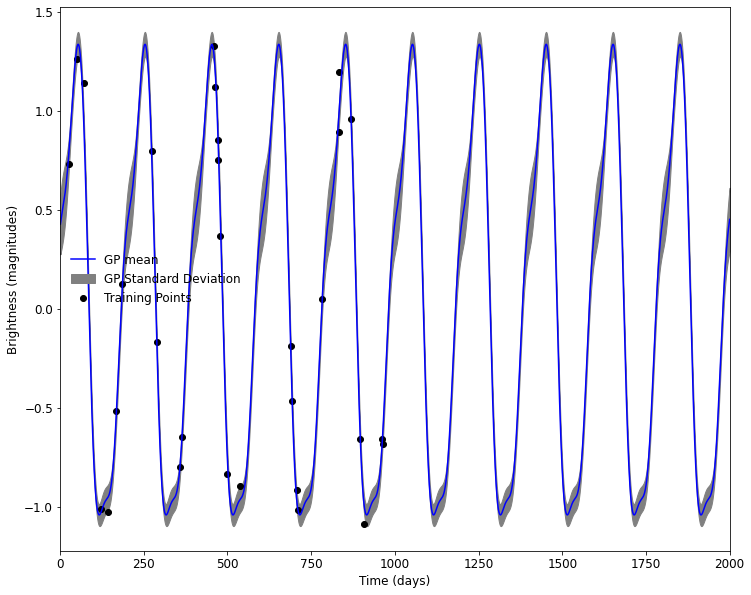

Mag at 1800 days:


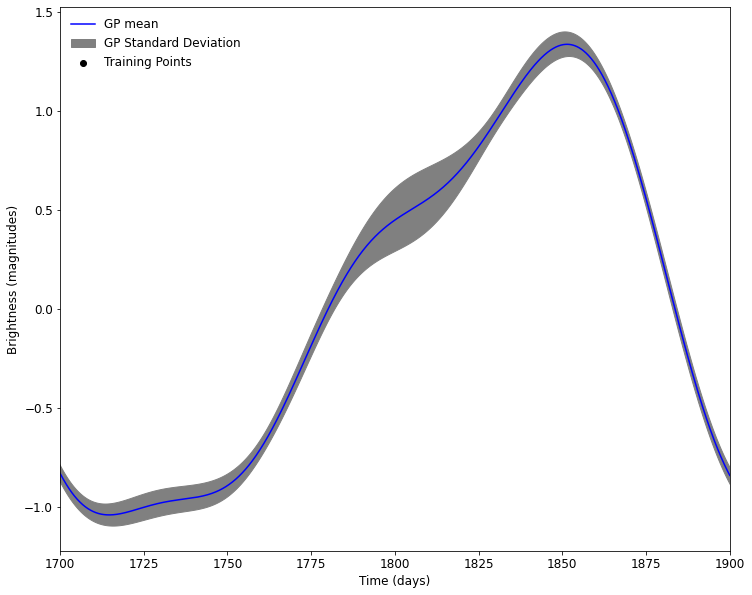

0.4478315264194158  +/-  0.15911370966281202


In [23]:

def pred(t_new,t_train,m_train,sigma_m_train,theta,T):
    n = t_new.size
    t_new = t_new.reshape(n,1)
    N = t_train.size
    t_train = t_train.reshape(N,1)
    m_train = m_train.reshape(N,1)
    
    
    
    mu=periodic_kernel(t_new,t_train.T,theta,T)@ np.linalg.solve(periodic_kernel(t_train,t_train.T,theta,T)+np.diag(sigma_m_train**2),m_train)
    cov=periodic_kernel(t_new,t_new.T,theta,T) -periodic_kernel(t_new,t_train.T,theta,T) @np.linalg.solve(periodic_kernel(t_train,t_train.T,theta,T)+np.diag(sigma_m_train**2),periodic_kernel(t_train,t_new.T,theta,T))
    
    return mu,cov


t_new = np.linspace(1,2000,10000)

mu,cov = pred(t_new,t,m,sigma_m,best_theta,best_T)


plt.figure(figsize=(12,10))
plt.plot(t_new,mu,color='blue',label='GP mean')
plt.fill_between(t_new,mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.scatter(t,m,color='black',label='Training Points')
plt.xlim(0,500)
plt.xlabel('Time (days)')
plt.ylabel('Brightness (magnitudes)')
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(t_new,mu,color='blue',label='GP mean')
plt.fill_between(t_new,mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.scatter(t,m,color='black',label='Training Points')
plt.xlim(0,1000)
plt.xlabel('Time (days)')
plt.ylabel('Brightness (magnitudes)')
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(t_new,mu,color='blue',label='GP mean')
plt.fill_between(t_new,mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.scatter(t,m,color='black',label='Training Points')
plt.xlim(0,2000)
plt.xlabel('Time (days)')
plt.ylabel('Brightness (magnitudes)')
plt.legend(frameon=False)
plt.show()

print('Mag at 1800 days:')



plt.figure(figsize=(12,10))
plt.plot(t_new,mu,color='blue',label='GP mean')
plt.fill_between(t_new,mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.scatter(t,m,color='black',label='Training Points')
plt.xlim(1700,1900)
plt.xlabel('Time (days)')
plt.ylabel('Brightness (magnitudes)')
plt.legend(frameon=False)
plt.show()

mu,cov = pred(np.array([1800]),t,m,sigma_m,best_theta,best_T)
print(mu[0][0],' +/- ',np.sqrt(cov[0][0])) 


# Question 5.1



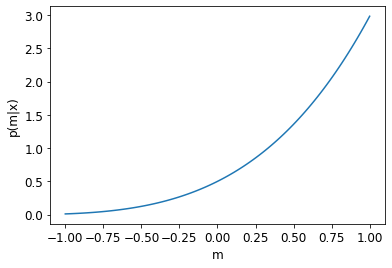

In [24]:
x=np.array([0.3,0.5,0.7,0.8])


def post_m(m,x):

    
    x = np.repeat(x.reshape(4,1),m.size,axis=1)

    m = m.reshape(1,m.size)
    
    
    return 0.5*np.prod(1+m*x,axis=0)


m = np.linspace(-1,1,100)


plt.plot(m,post_m(m,x))
plt.xlabel('m')
plt.ylabel('p(m|x)')
plt.show()

# Question 5.2.e

DATASET: 1
M0
w0: 0.10000000000000009  +/-  0.5
M1
w0: 0.8940594059405941  +/-  0.5098048549190267
w1: 0.7940594059405941  +/-  0.09950371902099892
log B10:  29.534221919797197


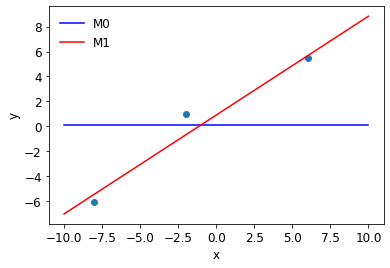

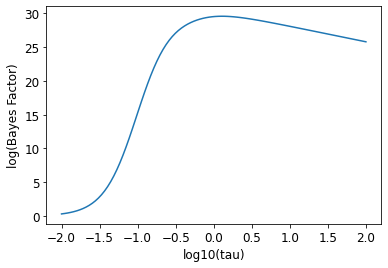

DATASET: 2
M0
w0: 1.5025  +/-  0.5
M1
w0: 1.4022029702970298  +/-  0.5098048549190267
w1: -0.1002970297029703  +/-  0.09950371902099892
log B10:  -1.799555802975085


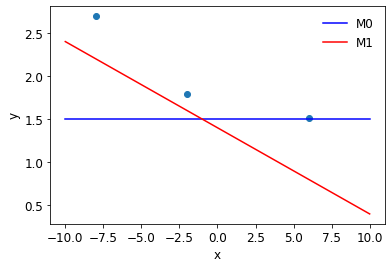

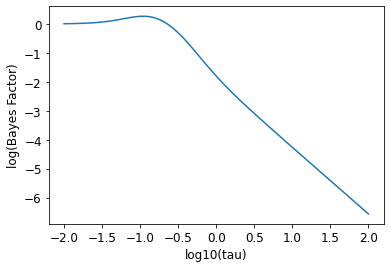

DATASET: 3
M0
w0: 7.25  +/-  0.5
M1
w0: 7.364851485148515  +/-  0.5098048549190267
w1: 0.1148514851485149  +/-  0.09950371902099892
log B10:  -1.641421644559243


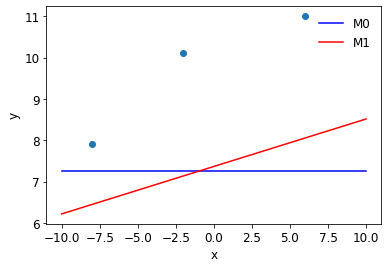

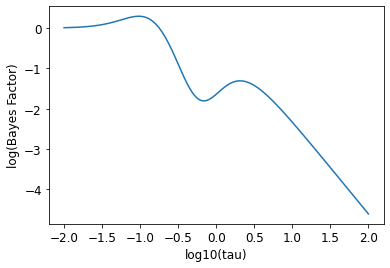

In [26]:
x = np.array([-8,-2,6])

D = np.column_stack((np.ones(3),x))

def post0(y,tau,sigma):
    
    cov = 1/((y.size/sigma**2)+(1/tau**2))
    
    mu = cov/sigma**2 * np.sum(y)
    
    return mu,cov
    


def post1(y,tau,sigma):
    y=y.reshape(3,1)
    cov = np.linalg.inv(sigma**(-2)*D.T@D+tau**(-2)*np.eye(2))
    mu = cov@D.T@y*sigma**2
    return mu,cov


def gauss(x,mu,cov):
    
    return (2*np.pi*cov)**(-0.5) * np.exp(-0.5*(x-mu)**2/cov)


def bayes_factor(mu,cov,tau):
    
    return gauss(0,mu[1,0],cov[1,1]) /gauss(0,0,tau**2)



    
y1 = np.array([-6.1,1,5.5])
y2 = np.array([2.7,1.8,1.51])
y3 = np.array([7.9,10.1,11.0])

ys = [y1,y2,y3]



for i,y in enumerate(ys):
               
    print('DATASET: '+str(i+1))
    
               
    print('M0')
    
    

    mu_,cov = post0(y,1,1)
    
    
    x_trials = np.linspace(-10,10,10)
    plt.plot(x_trials,mu_ +0*x_trials,color='blue',label='M0')

    print('w0:',mu_, ' +/- ',np.sqrt(cov))


    mu,cov = post1(y,1,1)

    print('M1')
    print('w0:',mu[0,0], ' +/- ',np.sqrt(cov[0,0]))
    print('w1:',mu[1,0] ,' +/- ',np.sqrt(cov[1,1]))
    plt.scatter(x,y)


    plt.plot(x_trials,mu[0,0]+mu[1,0]*x_trials,color='red',label='M1')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(frameon=False)

    print('log B10: ', -np.log(bayes_factor(mu,cov,1)))

    plt.show()


    tau_trials= 10**(np.linspace(-2,2,100))

    bfs = []
    bfs2= []
    for tau_trial in tau_trials:
    
        mu,cov = post1(y,tau_trial,1)
        bfs += [-np.log(bayes_factor(mu,cov,tau_trial))]

 

    plt.plot(np.log10(tau_trials),bfs)
    plt.xlabel('log10(tau)')
    plt.ylabel('log(Bayes Factor)')
    plt.show()
    
    


For all three datasets the Bayes factor for model 1 peaks at a small value of tau and then decreases since the prior is too broad on m1, meaning the evidence p(y) is less.